### Import Necessary Libraries and Data

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
root_path = '../Data_Files/'
df = pd.read_csv(root_path + 'hotels_reviews.csv')

In [3]:
df.head()

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.username,sourceURLs,websites,language,reviews.clean_text,userCity_upper,userProvince_upper,is_state,user_country,ratingCategory
0,AVwc252WIN2L1WUfpqLP,2016-10-30 21:42:42,2018-09-10 21:06:27,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,Paula,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,Language.ENGLISH,experience rancho valencia absolutely perfect ...,UNKNOWN,UNKNOWN,0,UNKNOWN,2.0
1,AVwc252WIN2L1WUfpqLP,2016-10-30 21:42:42,2018-09-10 21:06:27,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,D,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,Language.ENGLISH,amazing place everyone extremely warm welcomin...,UNKNOWN,UNKNOWN,0,UNKNOWN,2.0
2,AVwc252WIN2L1WUfpqLP,2016-10-30 21:42:42,2018-09-10 21:06:27,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,Ron,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,Language.ENGLISH,book 3 night stay rancho valencia play tennis ...,UNKNOWN,UNKNOWN,0,UNKNOWN,2.0
3,AVwdOclqIN2L1WUfti38,2015-11-28 19:19:35,2018-09-10 21:06:16,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,jaeem2016,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...,Language.ENGLISH,currently bed write past hr 1/2 dog bark squea...,RICHMOND,VIRGINIA,1,UNITEDSTATES,0.0
4,AVwdOclqIN2L1WUfti38,2015-11-28 19:19:35,2018-09-10 21:06:16,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,MamaNiaOne,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...,Language.ENGLISH,live md aloft home away home stay 1 night 7716...,LAUREL,MARYLAND,1,UNITEDSTATES,2.0


### Data Preparation

In [6]:
def split_words(text):
    return text.split()

df['reviews.clean_text'] = df['reviews.clean_text'].apply(lambda x: split_words(x))

In [7]:
reviews_list = df['reviews.clean_text'].tolist()

### Run LDA

In [4]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [9]:
dictionary = corpora.Dictionary(reviews_list)
doc_term_matrix = [dictionary.doc2bow(x) for x in reviews_list]

In [10]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        print("Running: Num_topics =", num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, 
                                                chunksize=1000, passes=20, iterations=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Iterate multiple number of topics to find the best number of topics.

In [11]:
start=1
limit=5
step=1
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=reviews_list, 
                                                        start=start, limit=limit, step=step)

Running: Num_topics = 1
Running: Num_topics = 2
Running: Num_topics = 3
Running: Num_topics = 4


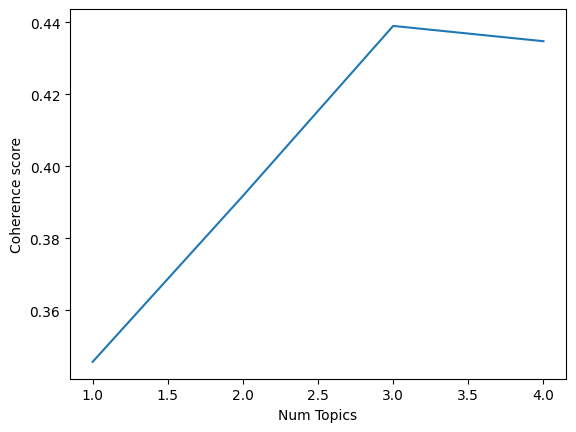

In [12]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

### Choose the best number of topics based on the highest coherence score.

In [13]:
# We can use the coherence score in topic modeling to measure how interpretable the topics are to humans. 
# In this case, topics are represented as the top N words with the highest probability of belonging to that particular topic. 
# Briefly, the coherence score measures how similar these words are to each other.

best_num_index = np.argmax(coherence_values)
best_num_model = model_list[best_num_index]

max_coherence_score = coherence_values[best_num_index]
best_num_topics = best_num_index+start # This is only for step=1

print("Max coherence: " + str(max_coherence_score))
print("Corresponding number of topic: " + str(best_num_topics))

Max coherence: 0.4389603826876212
Corresponding number of topic: 3


### Print Top 30 Most Salient Terms In Each Topic.

In [14]:
num_topics = best_num_topics
topic_words = []

for i in range(num_topics):
    tt = best_num_model.get_topic_terms(i,30)
    topic_words.append([dictionary[pair[0]] for pair in tt])
  
for i in range(len(topic_words)):
    print("Topic ", i+1, ":", topic_words[i], "\n")

Topic  1 : ['stay', 'we', 'thank', 'hotel', 'time', 'review', 'guest', 'experience', 'staff', 'take', 'service', 'hope', 'make', 'back', 'feedback', 'appreciate', 'see', 'manager', 'look', 'hear', 'glad', 'forward', 'visit', 'enjoy', 'please', 'share', 'next', 'great', 'welcome', 'soon'] 

Topic  2 : ['hotel', 'stay', 'room', 'great', 'staff', 'good', 'breakfast', 'clean', 'nice', 'location', 'friendly', 'area', 'comfortable', 'walk', 'restaurant', 'place', 'well', 'helpful', 'pool', 'would', 'close', 'enjoy', 'free', 'night', 'bed', 'also', 'time', 'price', 'love', 'parking'] 

Topic  3 : ['room', 'hotel', 'get', 'would', 'night', 'stay', 'one', 'bed', 'desk', 'check', 'go', 'like', 'front', 'could', 'clean', 'floor', 'day', 'breakfast', 'bathroom', 'good', 'door', 'work', 'use', 'we', 'say', 'nice', 'shower', 'need', 'bad', 'time'] 



### Visualize the topics using pyLDAvis

In [15]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(best_num_model, doc_term_matrix, dictionary)
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.077533  0.150782       1        1  41.507423
2     -0.127194 -0.128223       2        1  33.418991
0      0.204727 -0.022560       3        1  25.073586, topic_info=       Term          Freq         Total Category  logprob  loglift
240      we   6641.000000   6641.000000  Default  30.0000  30.0000
141   thank   4252.000000   4252.000000  Default  29.0000  29.0000
29    great   8912.000000   8912.000000  Default  28.0000  28.0000
177  review   2860.000000   2860.000000  Default  27.0000  27.0000
66     room  21310.000000  21310.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
153   visit   1365.099361   2550.354605   Topic3  -5.1050   0.7584
149    look   1464.651210   3376.805160   Topic3  -5.0346   0.5480
339   enjoy   1359.767397   3254.619882   Topic3  -5.1089   0.5106
298    next   1279.360820   3016.525501   Topic3  -5.1699   0.5256
29    great   1245.193059   8912.439747   Topic3  -5.1970  -0.5848

[230 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
16        1  0.319207           2
16        2  0.648710           2
16        3  0.031463           2
592       2  0.998434          ac
670       1  0.998045  affordable
...     ...       ...         ...
143       3  0.212916        work
15        1  0.371756       would
15        2  0.468097       would
15        3  0.159994       would
93        3  0.998962       write

[331 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

### Assigning reviews to their respective topics

In [16]:
map_topics_reviews = []

for count, rev in enumerate(best_num_model[doc_term_matrix]):
    map_topics_reviews.append([count, max(rev, key=lambda i: i[1])[0], max(rev, key=lambda i: i[1])[1]])

# review number, topic number, topic weight
map_topics_reviews

[[0, 0, 0.67945266],
 [1, 1, 0.5162384],
 [2, 1, 0.5853927],
 [3, 2, 0.8808111],
 [4, 0, 0.44349208],
 [5, 1, 0.8048676],
 [6, 1, 0.48214027],
 [7, 1, 0.9661535],
 [8, 2, 0.55189055],
 [9, 0, 0.51071966],
 [10, 1, 0.6212948],
 [11, 1, 0.6554386],
 [12, 2, 0.39862198],
 [13, 0, 0.56369483],
 [14, 1, 0.5573497],
 [15, 1, 0.593519],
 [16, 2, 0.5814334],
 [17, 2, 0.569198],
 [18, 1, 0.6162154],
 [19, 1, 0.6429351],
 [20, 1, 0.5158619],
 [21, 0, 0.40944213],
 [22, 2, 0.55545735],
 [23, 1, 0.83803666],
 [24, 1, 0.74041635],
 [25, 2, 0.7571322],
 [26, 2, 0.8338696],
 [27, 2, 0.8180886],
 [28, 2, 0.7341859],
 [29, 0, 0.89460325],
 [30, 2, 0.93227506],
 [31, 2, 0.6041414],
 [32, 1, 0.56500554],
 [33, 1, 0.75749916],
 [34, 1, 0.5758482],
 [35, 1, 0.9015388],
 [36, 2, 0.6644431],
 [37, 2, 0.8567521],
 [38, 2, 0.72851235],
 [39, 1, 0.8286704],
 [40, 1, 0.8708019],
 [41, 1, 0.94712013],
 [42, 0, 0.9445823],
 [43, 2, 0.96787983],
 [44, 1, 0.91399133],
 [45, 2, 0.71776485],
 [46, 1, 0.6834874],
 [47,

### Mapping reviews and topics to their ratings

In [27]:
mapped_df = pd.DataFrame(map_topics_reviews, columns=["Review", "Topic", "Weight"])
mapped_df = mapped_df.drop(["Review"], axis=1)

mapped_df["Rating"] = df.loc[:,"ratingCategory"]
mapped_df["Review"] = df.loc[:,"reviews.text"]

mapped_df.loc[mapped_df["Topic"] == 0, "Topic"] = 3
mapped_df.loc[mapped_df["Topic"] == 1, "Topic"] = 1
mapped_df.loc[mapped_df["Topic"] == 2, "Topic"] = 2
mapped_df

,Topic,Weight,Rating,Review
0,3,0.679453,2.0,Our experience at Rancho Valencia was absolute...
1,1,0.516238,2.0,Amazing place. Everyone was extremely warm and...
2,1,0.585393,2.0,We booked a 3 night stay at Rancho Valencia to...
3,2,0.880811,0.0,Currently in bed writing this for the past hr ...
4,3,0.443492,2.0,I live in Md and the Aloft is my Home away fro...
...,...,...,...,...
19696,2,0.746661,2.0,Bad: No casino.
19697,2,0.666600,0.0,Horrible
19698,2,0.777733,0.0,HORRIBLE HORRIBLE
19699,1,0.665109,1.0,Fun


### Count the Number of Reviews in each Topic

In [28]:
mapped_df_count = mapped_df.loc[:,['Topic', 'Rating']]
mapped_df_count["Count"] = 1
mapped_df_count = pd.pivot_table(mapped_df_count, index='Rating', values='Count', columns='Topic', aggfunc=np.sum, fill_value=0)
mapped_df_count = mapped_df_count.T
mapped_df_count

Rating,0.0,1.0,2.0
Topic,,,
1,141,4097,6507
2,1907,2734,1072
3,290,957,1996


### Plot stacked bar chart for the Number of Reviews in each Topic 

[Text(0, 0, 'Hotel Facilities'),
 Text(1, 0, 'Room Amenities'),
 Text(2, 0, 'Staff Service')]

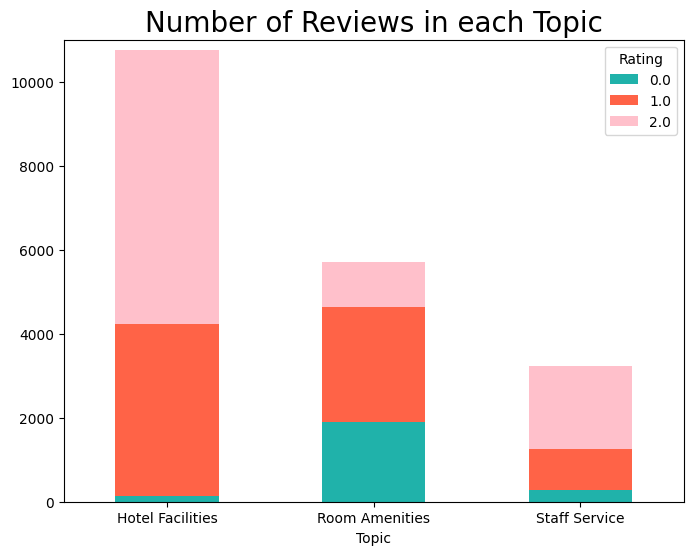

In [29]:
ax = mapped_df_count.plot.bar(stacked=True, color =['lightseagreen', 'tomato', 'pink'], figsize=(8,6))
ax.set_title('Number of Reviews in each Topic', fontsize=20)
ax.set_ylim(0,11000)
ax.set_xticklabels(['Hotel Facilities','Room Amenities','Staff Service'], rotation=0)

### Plot stacked bar chart for the Percentage of Reviews in each Topic

[Text(0, 0, 'Hotel Facilities'),
 Text(1, 0, 'Room Amenities'),
 Text(2, 0, 'Staff Service')]

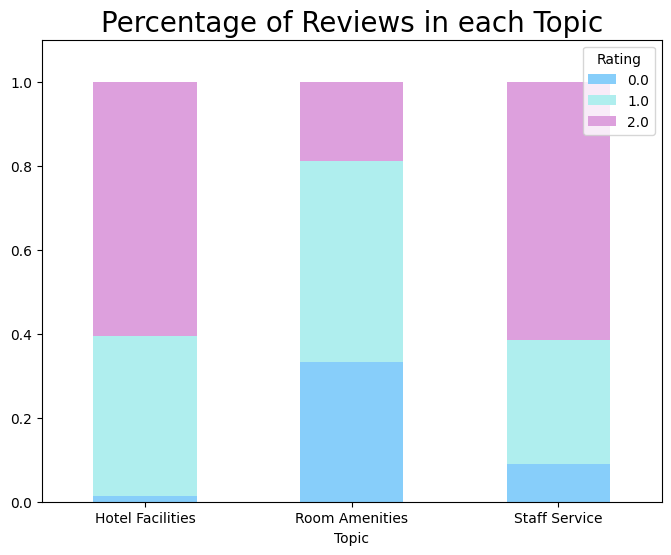

In [30]:
mapped_df_count_percent = mapped_df_count.copy()

for row in range(best_num_topics):
    row_sum = mapped_df_count_percent.iloc[row].sum()
    mapped_df_count_percent.iloc[row] = mapped_df_count_percent.iloc[row].apply(lambda x: x/row_sum)

ax = mapped_df_count_percent.plot.bar(stacked=True, color =['lightskyblue', 'paleturquoise', 'plum'], figsize=(8,6))
ax.set_title('Percentage of Reviews in each Topic', fontsize=20)
ax.set_ylim(0,1.1)
ax.set_xticklabels(['Hotel Facilities','Room Amenities','Staff Service'], rotation=0)

### See the top reviews from each topic

In [23]:
def see_rep_review(df, topic, num):
    print("Best", num, "reviews for Topic", str(topic) + ":")

    filtered_df = df.loc[df['Topic']==topic,:]
    sorted_filtered_df = filtered_df.sort_values("Weight", ascending=False)

    for n in range(num):
        print("Review #", str(n) + ":")
        print(sorted_filtered_df.iloc[n,3])

### Top 10 Reviews for Topic 1: Hotel Facilities

In [31]:
see_rep_review(mapped_df, 1, 10)

Best 10 reviews for Topic 1:
Review # 0:
My wife and I stayed at the Drury on Poydras on Friday night before the Jazz Half Marathon. We had stayed at the Drury before and enjoyed it very much. This time was no different. The hotel is clean and comfortable with a large inviting lobby. The have adopted valet-only parking which at 25 is expensive, but in line with other hotels in the area. The valets were very helpful and the service was excellent. The hotel offers a complimentary evening happy hour and breakfast with rather good food. We had a corner room, which was not a suite, but very spacious with a whirlpool bath. The room was comfortable, quiet, and had a nice view. The Drury is located at the edge of the French Quarter and provides easy access to the major sites. We had the added benefit of being only 1 block from the race start line at Lafayette Square. Overall, this is a fantastic place to stay in NOLA.
Review # 1:
This is a great hotel for everyone. It seems very secluded but i

### Top 10 Reviews for Topic 2: Room Amenities

In [32]:
see_rep_review(mapped_df, 2, 10)

Best 10 reviews for Topic 2:
Review # 0:
The grounds are dimly lit at night and it is hard to find your room at night. The room numbers are too small to read and not reflective so impossible to see. Parts of the parking lot are narrow and hard to drive your car or back out of your spot without the possibility of hitting a structure or landscaping or planter. The room was smaller than I expected since it had two beds. One bed was up against the window pressed right up on the a/c unit. The curtains were so long they hung over the a/c unit. When I turned it on the air flow blew directly behind the curtain trapping the air flow. I had to MacGyver some decorative pillows to keep the curtains flat to let the air flow into the room. There is only 1 plug by the sink. You can not have a hair appliance plugged in and the refrigerator at the same time. Your choice of cold food and drinks or groomed hair. The room was clean. I do not like the way they charge my room to my debit card. They charge y

### Top 10 Reviews for Topic 3: Staff Service

In [33]:
see_rep_review(mapped_df, 3, 10)

Best 10 reviews for Topic 3:
Review # 0:
Just had another spectacular stay at my favorite hotel in Seattle the Sorennto. I was in town to attend the annual Bumbershoot festival, and I wouldnt dream of staying anywhere else. The level of service here is nothing short of stellar. I cant thank Lisa and her team enough for handling my myriad requests. And every department went out of their way to personally greet me during my stay which of course is no surprise because this hotel is truly a home away from home gem. Cant wait to come back!Dear Troy,Thank you taking the time to share your recent return visit to Hotel Sorrento, on TripAdvisor, with other travelers.I was delighted to read that enjoyed the Bumbershoot Festival and found our hotel and team top notch and successfully able to resource any requests that you had.No need to dream of any other location in Seattle, we want you back! Please allow us to coordinate your return visit and personally oversee any requests that you may have. W